# topic modeling playground
In this notebook, different concepts for topic modeling will be tested and evaluated.

In [39]:
import re

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# preprocessing
import nltk

nltk.download('stopwords')
import spacy

# Plotting
import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Structure

In [40]:
from enum import Enum


class Party(Enum):
    AFD = 0
    CDU = 1
    FDP = 2
    GRUENE = 3
    LINKE = 4
    SPD = 5




## Preprocessing

In [41]:
nlp = spacy.load('de_core_news_md')
from nltk.corpus import stopwords
from spacy.lang.de.stop_words import STOP_WORDS

# stopwords
nltk_stopwords = stopwords.words('german')

# build stopwords list
all_stopwords = list(set(STOP_WORDS) | set(nltk_stopwords))
with open('custom_stopwords.txt', 'r', encoding='utf-8') as f:
    all_stopwords += [line.strip() for line in f.readlines()]

# Load files
party_text = {}
for party in Party:
    all_stopwords.extend(['{}'.format(party.name.lower())])
    with open('resources/' + party.name + '.txt', encoding='utf-8', errors='ignore') as txt:
        file = " ".join(l for l in txt)
        # remove gender *
        file = re.sub(r'\*innen(\w*)\s', r'\1 ', file)
    party_text[party] = file



In [42]:
def prepare_data(parties: [Party]):
    # get sections
    sections = []
    for partie in parties:
        sections_of_partie = re.split(r'\n\s*\n', party_text[Party.FDP])
        sections.extend(sections_of_partie)

    partie_wordbags_mod = []

    for section in sections:
        partie_wordbag = gensim.utils.simple_preprocess(section)

        #filter stopwords
        partie_wordbag_spacy = [word for word in partie_wordbag if word not in all_stopwords]

        partie_wordbags_mod.append(partie_wordbag_spacy)

    # make bigrams
    bigram = gensim.models.Phrases(partie_wordbags_mod, min_count=5, threshold=100)
    # make trigrams
    trigram = gensim.models.Phrases(bigram[partie_wordbags_mod], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in all_stopwords])
        return texts_out

    words_trigrams = make_trigrams(partie_wordbags_mod)
    words_lematized = lemmatization(words_trigrams)

    id2word = corpora.Dictionary(words_lematized)
    texts = words_lematized
    corpus = [id2word.doc2bow(text) for text in texts]

    return corpus, id2word, words_lematized


In [87]:

corpus, id2word, words_lematized = prepare_data([Party.FDP])
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            iterations=100
                                            )

lda_model.print_topics(num_topics=10, num_words=10)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
# a measure of how good the model is. lower the better.

# TODO change c_v https://www.baeldung.com/cs/topic-modeling-coherence-score
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.118433825370161

Coherence Score:  -5.019765895895186


##V

In [65]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

c:\users\fabik\pycharmprojects\textanalytics\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.032572 -0.025864       1        1  14.920714
4      0.028758  0.046107       2        1  12.695256
6      0.132168  0.017226       3        1  12.200439
9     -0.035891 -0.041575       4        1  11.115791
5     -0.002751 -0.077265       5        1  10.027366
7     -0.035232  0.045636       6        1   8.799333
2      0.008660 -0.042683       7        1   8.474176
0     -0.000870 -0.013807       8        1   8.468348
3      0.004596  0.027740       9        1   7.156557
1     -0.066866  0.064485      10        1   6.142020, topic_info=                Term       Freq      Total Category  logprob  loglift
760            daten  15.000000  15.000000  Default  30.0000  30.0000
788            mobil   7.000000   7.000000  Default  29.0000  29.0000
743   altersvorsorge  14.000000  14.000000  Default  28.0000  28.0000
798   selbstständige  11.000000  11.000000  Default  27.0000  27.0000
1092       beruflich  13.000000  13.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
619           ausbau   1.661180  18.178949  Topic10  -6.0772   0.3973
30           einzeln   1.556779  14.315791  Topic10  -6.1421   0.5713
62            kosten   1.353501  10.364900  Topic10  -6.2820   0.7543
375         digitale   1.446832  28.008104  Topic10  -6.2154  -0.1731
123       wettbewerb   1.387057  26.352346  Topic10  -6.2576  -0.1544

[708 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
2094      1  0.323501              abbau
2094      4  0.323501              abbau
613       1  0.358393       abgabenquote
613      10  0.358393       abgabenquote
2824      6  0.863585         abgeordnet
...     ...       ...                ...
1831      5  0.161571  öffentlichen_raum
1831      6  0.161571  öffentlichen_raum
1604      5  0.456640        ökobilanzen
2874      6  0.657968      überschreiten
255       2  0.651637        überzeugung

[1565 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 7, 10, 6, 8, 3, 1, 4, 2])

# other models

In [88]:
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=10, chunksize=100)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lsi_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

lsi_model.print_topics(num_topics=10)


Coherence Score:  -5.359567612732676


[(0,
  '0.288*"unternehmen" + 0.158*"digital" + 0.152*"chancen" + 0.148*"nachhaltig" + 0.142*"entwicklung" + 0.141*"freiheit" + 0.133*"wettbewerb" + 0.133*"digitale" + 0.131*"international" + 0.120*"bildung"'),
 (1,
  '0.357*"bildung" + -0.346*"unternehmen" + 0.296*"schulen" + 0.281*"beruflich" + 0.184*"beruflichen_bildung" + 0.147*"weiterbildung" + 0.140*"hochschulen" + 0.112*"leben" + 0.110*"finanziell" + 0.108*"digital"'),
 (2,
  '-0.437*"unternehmen" + 0.316*"freiheit" + 0.167*"land" + 0.165*"menschenrechte" + -0.164*"altersvorsorge" + -0.135*"gesetzlich" + -0.110*"arbeiten" + 0.108*"global" + 0.104*"nachhaltig" + 0.097*"richtung"'),
 (3,
  '0.234*"unternehmen" + -0.193*"schutz" + 0.153*"bildung" + 0.149*"freiheit" + -0.136*"gewalt" + -0.126*"altersvorsorge" + -0.123*"menschenrechte" + -0.119*"klaren" + -0.114*"polizei" + 0.113*"beruflich"'),
 (4,
  '-0.372*"co" + 0.241*"unternehmen" + 0.208*"freiheit" + -0.191*"klimaschutz" + -0.135*"kraftstoffe" + 0.121*"menschenrechte" + -0.119*

In [89]:
from pprint import pprint

hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word,)
pprint(hdp_model.show_topics())

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=hdp_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.002*freiheit + 0.002*notlagen + 0.002*überzeugung + 0.002*global + '
  '0.002*alt + 0.002*planungs + 0.002*verspäten + 0.001*unklar + 0.001*liberal '
  '+ 0.001*wasser + 0.001*einkommen + 0.001*einschränken + 0.001*verbesserung '
  '+ 0.001*gefordert + 0.001*pariser + 0.001*miteinander + 0.001*entnehmen + '
  '0.001*belohnen + 0.001*hieraus + 0.001*schulfächer'),
 (1,
  '0.002*staaten + 0.002*studium + 0.002*pariser + 0.002*wachsen + '
  '0.001*erwärmung + 0.001*desinformation + 0.001*gleichgesinnten + '
  '0.001*bioökonomie + 0.001*leib + 0.001*clevere + 0.001*kreml + '
  '0.001*international + 0.001*hinein + 0.001*progressiv + 0.001*politik + '
  '0.001*erlauben + 0.001*bergen + 0.001*ideologische + 0.001*aktive + '
  '0.001*beamtinnen'),
 (2,
  '0.002*letztlich + 0.002*gefangen + 0.002*aufbewahren + 0.002*hintergrund + '
  '0.002*chancen + 0.002*gtaz + 0.001*volkes + 0.001*hilfsleistungen + '
  '0.001*verkehrsplanung + 0.001*wohnraum + 0.001*schwellen + '
  '0.001*übertrag

# Plot coherence score

In [104]:
from datetime import datetime
import matplotlib.pyplot as plt


def plot_coherence(coherence, max_topics, max_iterations, parties, iteration_intervall=25):
    corpus, id2word, words_lematized = prepare_data(parties)

    data = {}
    for iterations in range(iteration_intervall, max_iterations, iteration_intervall):
        statistics = {}
        for topics in range(1, max_topics):
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=topics,
                                                        iterations=iterations
                                                        )
            coherence_model_lda = CoherenceModel(model=lda_model, texts=words_lematized, dictionary=id2word,
                                                 coherence=coherence, corpus=corpus)
            coherence_lda = coherence_model_lda.get_coherence()
            statistics[topics] = coherence_lda
        data[iterations] = statistics

    for key, value in data.items():
        plt.plot(list(value.keys()), list(value.values()), label=key)
    plt.legend()
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence score for different number of topics')

    plt.savefig(f'{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_coherence_score_{coherence}_for_{parties[0]}_{len(parties)}.png')

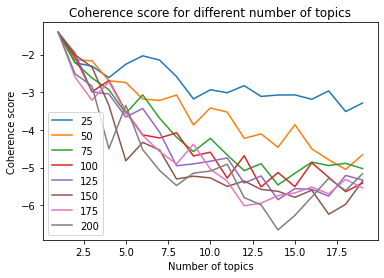

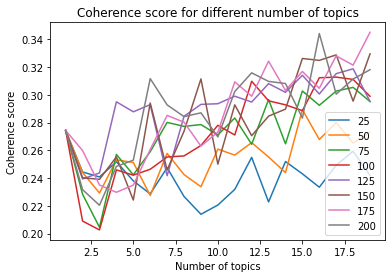

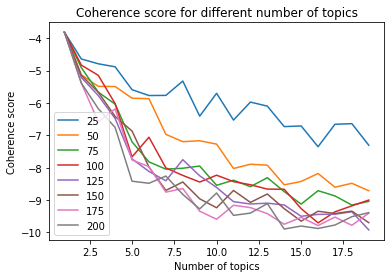

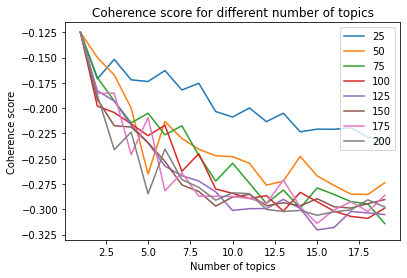

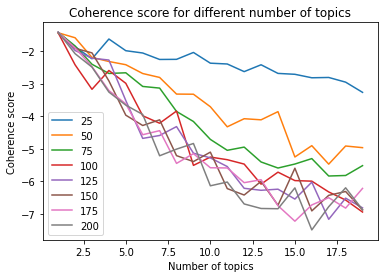

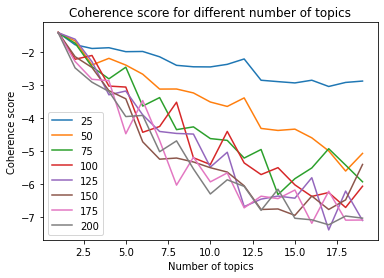

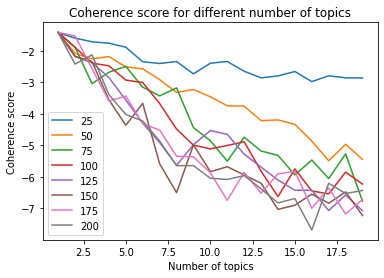

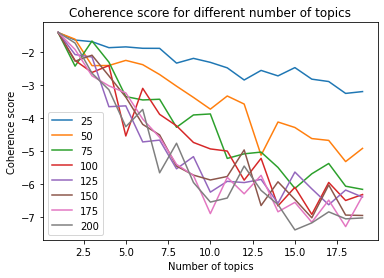

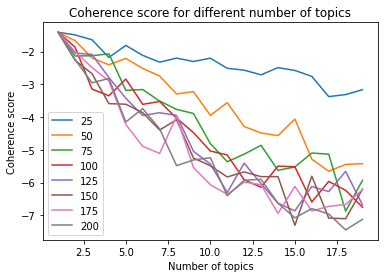

In [105]:
all_parties = [p for p in Party]

plot_coherence('u_mass', max_iterations=225, max_topics=20, parties=all_parties)
plot_coherence('c_v', max_iterations=225, max_topics=20, parties=all_parties)
plot_coherence('c_uci', max_iterations=225, max_topics=20, parties=all_parties)
plot_coherence('c_npmi', max_iterations=225, max_topics=20, parties=all_parties)

plot_coherence('u_mass', max_iterations=225, max_topics=20, parties=[Party.SPD])
plot_coherence('u_mass', max_iterations=225, max_topics=20, parties=[Party.CDU])
plot_coherence('u_mass', max_iterations=225, max_topics=20, parties=[Party.FDP])
plot_coherence('u_mass', max_iterations=225, max_topics=20, parties=[Party.GRUENE])
plot_coherence('u_mass', max_iterations=225, max_topics=20, parties=[Party.LINKE])
